# August 24, 2022: ISC matrices: MAX trial level responses: MAX ROIs: Schaefer networks

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jul22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils
import helpers.isc_utils as isc_utils

In [2]:
''''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

# ROIs
args.max_readme_file = f"/home/govindas/parcellations/MAX_85_ROI_masks/README_MAX_ROIs_final_gm_85.txt"
max_readme_df = pd.read_csv(
    args.max_readme_file,
    sep='\t'
)
max_readme_df = max_readme_df.sort_values(by=['Schaefer_network'])
display(max_readme_df)

args.roi_names = (max_readme_df['Hemi'] + ' ' + max_readme_df['ROI']).values
args.nw_names = max_readme_df['Schaefer_network'].values
args.roi_idxs = max_readme_df.index.values
args.num_rois = len(args.roi_idxs)

# trial level responses
with open(f"{proj_dir}/data/max/exploratory_data_trial_level_responses.pkl", 'rb') as f:
    X = pickle.load(f)

# change roi ordering
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

,Hemi,ROI,Index,Voxels,File_Name,Schaefer_network
35,R,IFG-1,36,329,IFG_R_6_1.nii.gz,Cont
37,R,IFG-2,38,293,IFG_R_6_2.nii.gz,Cont
2,R,lat. OFC,3,56,r-lOFC_p.6_2mm_Amunts.nii.gz,Cont
38,L,IFG-2,39,337,IFG_L_6_2.nii.gz,Cont
6,R,dlPFC,7,75,r-dlPFC_Shackman_2mm.nii.gz,Cont
...,...,...,...,...,...,...
64,L,Hippocampus tail,65,102,l-hippocampus-tail_Tian2020_2mm.nii.gz,Subcort
54,L,BST,55,9,lBNST.nii.gz,Subcort
84,L,CrusI-krienen,85,119,l-cerebellum-crusI_KrienenBuckner_sphere.nii.gz,Subcort
61,R,Hippocampus body,62,192,r-hippocampus-body_Tian2020_2mm.nii.gz,Vis


In [3]:
'''
plotting tick labels
'''
ticks = []
for nw in np.unique(args.nw_names):
    ticks.append(np.where(args.nw_names == nw)[0].shape[0])
args.ticks = np.array(ticks)
print(args.ticks)

minor_ticks = np.cumsum(args.ticks)
args.major_ticks = minor_ticks - args.ticks // 2
args.minor_ticks = minor_ticks[:-1]
print(args.minor_ticks)
print(args.major_ticks)

args.major_tick_labels = np.unique(args.nw_names)
print(args.major_tick_labels)

[ 9 16  2  6 18 32  2]
[ 9 25 27 33 51 83]
[ 5 17 26 30 42 67 84]
['Cont' 'Default' 'DorsAttn' 'Limbic' 'SalVentAttn' 'Subcort' 'Vis']


### `early` and `late` periods 

In [4]:
ts = isc_utils.get_block_time_series(args, X)

minimum number of trials = 11


### Intersubject correlations

**Following the pipeline in ISC tutorial**

Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

Statistical significance was assessed by a nonparametric bootstrap hypothesis test resampling left-out subjects (Leavo-one-out (LOO)). 
<!-- and corrected for multiple tests by controlling FDR at .05. -->

i.e.:
1. Compute leave-one-out (LOO) ISC and ISFC values
2. Bootstrap hypothesis testing, (Chen et al.2016: https://doi.org/10.1016/j.neuroimage.2016.05.023)
<!-- 3. Multiple tests correction: False Discovery Rate (FDR) at 0.05. -->

LOO method relates to computing ISFC values, as the mean time series of the remaining subjects converges to the common signal across subjects.

In [5]:
'''
leave-one-out ISFC
bootstrap
'''
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise = False
args.vectorize_isfcs = True
args.n_bootstraps = 1000

corrs, bootstraps, rois = isc_utils.get_isfcs(args, ts)

# # multiple tests correction
# q = {}; z = {};
# q[block][corr_name] = multipletests(bootstraps[block][corr_name][2], method='fdr_by')[1]
# z[block][corr_name] = np.abs(norm.ppf(q[block][corr_name]))

condition safe_early and correlation isfc : 35.182072829131656 %significant roi(-pairs)
condition safe_early and correlation isc : 41.1764705882353 %significant roi(-pairs)
condition safe_late and correlation isfc : 16.89075630252101 %significant roi(-pairs)
condition safe_late and correlation isc : 20.0 %significant roi(-pairs)
condition threat_early and correlation isfc : 29.29971988795518 %significant roi(-pairs)
condition threat_early and correlation isc : 32.94117647058823 %significant roi(-pairs)
condition threat_late and correlation isfc : 14.397759103641457 %significant roi(-pairs)
condition threat_late and correlation isc : 14.117647058823529 %significant roi(-pairs)


Showing ISFC values for each period only for the *significant* roi-pairs.

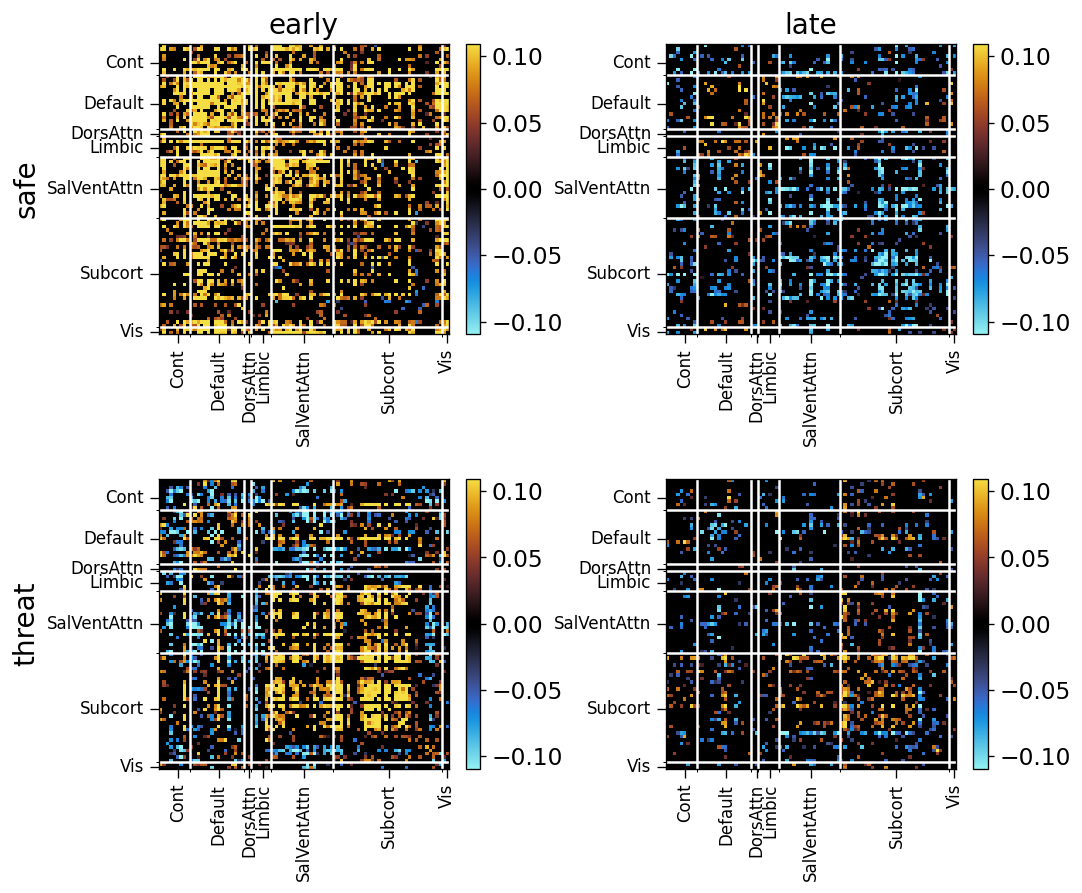

In [6]:
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(args, bootstraps, rois)

isc_utils.plot_isfcs(args, observed_isfcs, significant_rois)

### statistical testing: pairwise non parametric permutation test

We perform a non parametric pairwise permutation test suggested by Chen et al.2016 (https://doi.org/10.1016/j.neuroimage.2016.05.023) to compare ISFC matrices between any two pairs of conditions. 

We use statistic in the permutation test as the difference between median ISFC matrices between two conditions.

We plot the statistic between every pair of conditions only for the roi-pairs that differentiate significantly between the conditions.

In [7]:
stats_results = isc_utils.get_comparison_stats(args, corrs)

diff_isfcs, diff_pvals = isc_utils.get_diff_isfcs(args, stats_results, significant_rois)

cond_idx = {}
for idx, block in enumerate(corrs.keys()):
    cond_idx[block] = idx

6it [00:51,  8.59s/it]


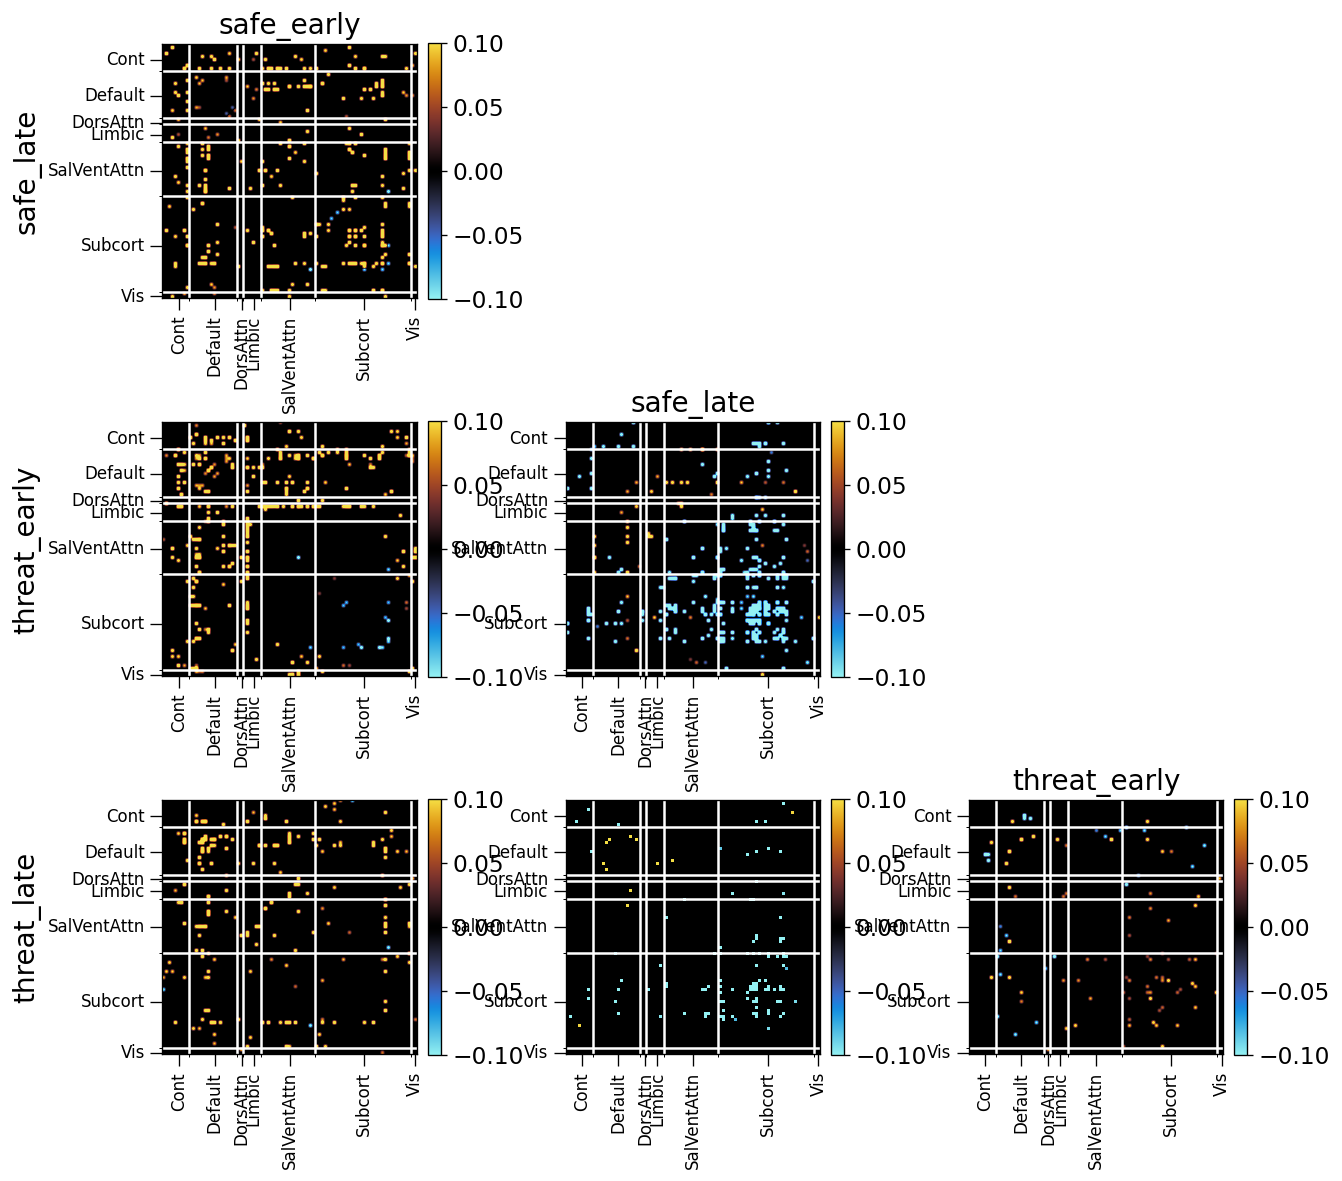

In [8]:
isc_utils.plot_isfc_comparisons(args, corrs, diff_isfcs)